### Import packages and files

In [1]:
# import packages
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
%matplotlib inline

from PIL import Image, ImageEnhance

import numpy as np
import pandas as pd

import cv2 as cv

In [2]:
# load reference d-spacing values
ref = pd.read_csv('Co3O4_d_spacing_(ICSD36256).csv', encoding ='latin_1')
ref

,Material,h,k,l,d-spacing (Å),d-spacing (nm),Inverse distance (nm-1),Intensity,Multiplicity,Color
0,Co3O4,4,0,0,2.01800,0.201800,4.955401,91777.40,6,#1b9e77
1,Co3O4,2,2,2,2.33019,0.233019,4.291496,27247.00,8,#7570b3
2,Co3O4,3,1,1,2.43380,0.243380,4.108801,76335.80,24,#7570b3
3,Co3O4,2,2,0,2.85388,0.285388,3.504002,32617.10,12,#e6ab02
4,Co3O4,2,0,0,4.03600,0.403600,2.477701,91777.40,6,#1b9e77
5,Co3O4,1,1,1,4.66037,0.466037,2.145752,7683.24,8,#7570b3
6,Co3O4,1,1,0,5.70776,0.570776,1.752001,32617.10,12,#e6ab02
7,Co3O4,1,0,0,8.07200,0.807200,1.238850,91777.40,6,#1b9e77


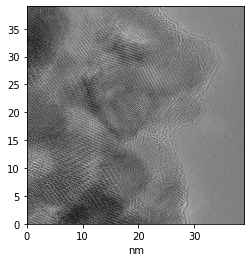

In [3]:
# load TEM image
file = 'Co3O4_0pass_500k.png'  # change the file name here
image = Image.open(file)

# calibrate the scale of the TEM image
shape = image.size[0]

# each magnification should have its own scale (nm/pixel)
scale_dict = {'500k': 39.02/2048}   # only 500k is included here

sampling_interval = scale_dict['500k']
total_len = shape * sampling_interval

# inspect TEM image
plt.imshow(image, cmap='gray', extent=[0, total_len, 0, total_len]) # extent is used to plot nm instead of index
plt.xlabel('nm')
plt.show()

### Perform FFT and get power spectrum

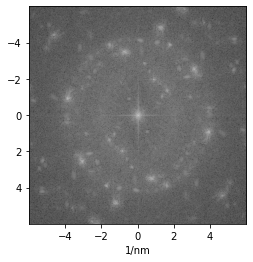

In [4]:
# perform 2D FFT
fft_image = np.fft.fft2(image)

# calculate power spectrum
power_spectrum = np.abs(fft_image)**2

# shift zero frequency component to center
power_spectrum = np.fft.fftshift(power_spectrum)

# log power spectrum for better visualization
log_power_spectrum = np.log(power_spectrum)

# calculate the sampling frequencies (i.e. the axes of the FFT image), given a window length n and a sample spacing d
freq_hz = np.fft.fftfreq(shape, sampling_interval)  # "Hz" here is just a label, actually it is "nm-1"

# sort the frequency array because np.fft.fftfreq by default is not from smallest to largest values
freq_sorted = np.sort(freq_hz)
############################################
# we don't have to consider the very high absolute frequency values (i.e. the very small d-spacing values)
# define crop range (nm-1)
crop_min = -6
crop_max = 6

# find the index of the crop range
freq_crop_index = np.where((freq_sorted >= crop_min) & (freq_sorted <= crop_max))[0]
# map index back to frequency (nm-1)
freq_crop = freq_sorted[freq_crop_index]

# crop the power spectrum
FFT_crop = log_power_spectrum[freq_crop_index[0]:freq_crop_index[-1], freq_crop_index[0]:freq_crop_index[-1]]
############################################
# normalize the image values to 0-255 with opencv
normalized_image = cv.normalize(FFT_crop, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)    # dtype = cv.CV_8U

plt.imshow(normalized_image, cmap='gray', extent=[freq_crop[0], freq_crop[-1], freq_crop[-1], freq_crop[0]])    # extent is used to plot nm-1 instead of index
plt.xlabel('1/nm')
plt.show()

### Adjust brightness and contrast of the power spectrum

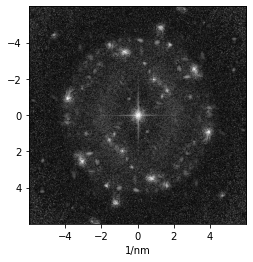

In [5]:
# power spectrum tends to be too bright
# first reduce the brightness, then apply further brightness/contrast refinement
############################################
# first apply manual brightness reduction
alpha = 1.0 # contrast control (1.0-3.0)
beta = -40  # brightness control 
manual_result = cv.convertScaleAbs(normalized_image, alpha=alpha, beta=beta)
############################################
# then apply further brightness and contrast optimization with optional histogram clipping
# define a function to automatically find the best alpha and beta
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    # assume input image is 2D numpy array, greyscale, normalized to 0-255
    gray = image.astype('uint8')

    # Calculate grayscale histogram
    hist = cv.calcHist([gray], [0], None, [256], [0, 256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    return alpha, beta
############################################
# apply automatic brightness and contrast refinement
clip_percent = 1.5  # higher values mean more contrast
alpha, beta = automatic_brightness_and_contrast(normalized_image, clip_hist_percent=clip_percent)
image_bc = cv.convertScaleAbs(manual_result, alpha=alpha, beta=beta)
############################################
# plot the power spectrum after brightness and contrast adjustment
plt.imshow(image_bc, cmap='gray', extent=[freq_crop[0], freq_crop[-1], freq_crop[-1], freq_crop[0]])
plt.xlabel('1/nm')
plt.show()

### Pick peaks using `ginput`

> `ginput` can only be used with a GUI backend of `matplotlib`, e.g. 'Qt5Agg'

Instructions:
- Always select peaks in pair, i.e. after picking a peak on the spectrum, the next peak should be centrosymmetric to it (this is important for calculating the distance later)
- Left mouse button to select peaks
- Right mouse button to cancel the last selected peak
- Middle mouse button to end the peak picking session

In [6]:
# settings for interactive plot (ginput)
import matplotlib
matplotlib.use('Qt5Agg')    # change to GUI-based backend for interactive plot

from matplotlib.widgets import Cursor
cursor_color = 'red'
cursor_width = 1

peak_color = 'red'
peak_size = 5

In [7]:
# initialize x y coordinates (use this if you are picking peaks from scratch)
# x_coords = []
# y_coords = []
############################################
# x y coordinates of the peaks (use this if you have picked peaks from the previous run)
x_coords = [215.51288933973441, 253.66736649787356, 296.2504883261538, 172.24843756220167, 200.52363045617977, 267.6346304575495, 220.2821989845018, 247.5353969546012, 346.11430199214624, 122.69939833276393, 322.2319417369813, 146.8761605505064, 129.62805092560723, 339.95916551812763, 354.3325902055436, 114.77551208194406, 387.39146698660034, 83.15397776962892, 384.9958962053644, 83.63309192587612, 355.290818518038, 113.33816961320247, 339.48005136188044, 129.14893676936003, 327.9813116119476, 141.12679067554, 316.96168601826207, 150.709073800484, 261.8635580498342, 205.80720176891188, 295.8806631433853, 172.74832498785514, 229.28379542502464, 238.38696439372143, 275.2787544247558, 192.8711195502375, 302.1091471745989, 166.04072680039437, 282.3311326199703, 186.26988812166817, 181.78705685173645, 286.0305390873666, 335.79929939664555, 130.81993398028993]
y_coords = [198.72406772771663, 269.58238244997506, 180.32815909789957, 286.9562961559134, 310.80284437975035, 156.82227584868883, 345.2100068170008, 122.41511341143837, 194.3065542856214, 273.03763657149227, 133.80472858269223, 335.0326742065158, 315.8681079566279, 151.53195236383863, 134.28384273893943, 334.07444589402144, 218.1288200821993, 250.22946855076162, 270.83137726939117, 197.52691136356975, 290.9541718317736, 175.96677433244577, 315.8681079566279, 152.01106652008582, 328.80419017530227, 138.59587014516427, 343.17761486271826, 125.18067377024266, 370.0080076125614, 98.3502810203995, 384.86054645622454, 83.01862802048913, 394.92194373741575, 72.95723073929798, 76.79014398927558, 390.1308021749437, 82.06039970799475, 385.33966061247173, 46.65921172086331, 422.23199403019714, 275.7143519932474, 191.9107682351918, 357.1967970852709, 108.42927001650492]

Total number of peaks: 44
x: 
[215.51288933973441, 253.66736649787356, 296.2504883261538, 172.24843756220167, 200.52363045617977, 267.6346304575495, 220.2821989845018, 247.5353969546012, 346.11430199214624, 122.69939833276393, 322.2319417369813, 146.8761605505064, 129.62805092560723, 339.95916551812763, 354.3325902055436, 114.77551208194406, 387.39146698660034, 83.15397776962892, 384.9958962053644, 83.63309192587612, 355.290818518038, 113.33816961320247, 339.48005136188044, 129.14893676936003, 327.9813116119476, 141.12679067554, 316.96168601826207, 150.709073800484, 261.8635580498342, 205.80720176891188, 295.8806631433853, 172.74832498785514, 229.28379542502464, 238.38696439372143, 275.2787544247558, 192.8711195502375, 302.1091471745989, 166.04072680039437, 282.3311326199703, 186.26988812166817, 181.78705685173645, 286.0305390873666, 335.79929939664555, 130.81993398028993]
y: 
[198.72406772771663, 269.58238244997506, 180.32815909789957, 286.9562961559134, 310.80284437975035, 156.822275

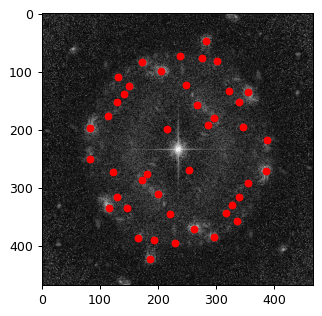

In [8]:
# create axis object
fig, ax = plt.subplots()

# plot the power spectrum after brightness and contrast adjustment
ax.imshow(image_bc, cmap='gray')
############################################
# add a cursor for better peak picking
cursor = Cursor(ax, useblit=True, color=cursor_color, linewidth=cursor_width)

# add a zoom function using scroll
def on_scroll(event):
    # Get the current x and y limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Set the zoom factor
    zoom_factor = 1.1 if event.button == 'down' else 0.9

    # Calculate new limits based on the zoom factor
    xcenter = (xlim[1] + xlim[0]) / 2
    ycenter = (ylim[1] + ylim[0]) / 2
    xdist = (xlim[1] - xlim[0]) / 2
    ydist = (ylim[1] - ylim[0]) / 2
    new_xdist = xdist * zoom_factor
    new_ydist = ydist * zoom_factor

    # Set the new limits
    ax.set_xlim(xcenter - new_xdist, xcenter + new_xdist)
    ax.set_ylim(ycenter - new_ydist, ycenter + new_ydist)
    fig.canvas.draw_idle()
    
# connect the scroll event to the zoom function
fig.canvas.mpl_connect('scroll_event', on_scroll)
############################################
# plot the initial points
ax.plot(x_coords, y_coords, color = peak_color, marker = 'o', markersize = peak_size, linestyle = 'None')

# get interactive points using ginput
selected_points = plt.ginput(n=0, timeout=0)
# append the selected points to the x and y coordinates
for point in selected_points:
    x_coords.append(point[0])
    y_coords.append(point[1])

# plot all the selected points
ax.plot(x_coords, y_coords, color = peak_color, marker = 'o', markersize = peak_size, linestyle = 'None')
plt.show()

print(f'Total number of peaks: {len(x_coords)}')
print(f'x: \n{x_coords}')
print(f'y: \n{y_coords}')

In [9]:
# switch back to inline for other plots
%matplotlib inline

In [10]:
# put the selected points into a dataframe
# since we always pick peaks in a pair (centrosymmetric pairs), the first point goes to x1, y1, and the second point goes to x2, y2
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(0, len(x_coords), 2):
    x1.append(x_coords[i])
    y1.append(y_coords[i])
    x2.append(x_coords[i+1])
    y2.append(y_coords[i+1])

# create a dataframe
peak_df = pd.DataFrame({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})

# round the coordinates to the nearest integer, and convert to int
peak_df = peak_df.round(0).astype(int)

# calculate the distance to the origin for each point
# take the average of the two points from each pair to reduce errors
def distance_to_origin(df):
    # convert coordinates from indices to frequency (nm-1)
    x1 = freq_crop[df['x1'].values]
    y1 = freq_crop[df['y1'].values]
    x2 = freq_crop[df['x2'].values]
    y2 = freq_crop[df['y2'].values]

    distance_1 = np.sqrt(x1**2 + y1**2)
    distance_2 = np.sqrt(x2**2 + y2**2)
    distance_reciprocal = (distance_1 + distance_2) / 2
    return distance_reciprocal

peak_df['Distance to origin (nm-1)'] = distance_to_origin(peak_df)

# calculate the distance in real space (nm)
peak_df['d-spacing (nm)'] = 1 / peak_df['Distance to origin (nm-1)']

# sort the dataframe by d-spacing
peak_df = peak_df.sort_values(by='d-spacing (nm)')

peak_df

,x1,y1,x2,y2,Distance to origin (nm-1),d-spacing (nm)
19,282,47,186,422,4.960188,0.201605
18,302,82,166,385,4.255795,0.234974
15,296,385,173,83,4.178482,0.239321
17,275,77,193,390,4.146118,0.241189
21,336,357,131,108,4.132914,0.241960
16,229,395,238,73,4.127720,0.242264
7,354,134,115,334,3.993376,0.250415
9,385,271,84,198,3.968818,0.251964
8,387,218,83,250,3.916961,0.255300
14,262,370,206,98,3.558494,0.281018


### Assign peaks by comparing to the reference

In [11]:
# compare the calculated d-spacing values to the reference values
# return the most likely d-spacing matches
############################################
# define a tolerance for the d-spacing when compared to the reference values (nm)
# only consider those matches if the difference is less than the tolerance
d_spacing_tol = 0.015

# extract the reference d-spacing values
d_spacing_ref = ref['d-spacing (nm)']

# define a function to find the best d-spacing match
def d_spacing_1match(d_spacing):
    # calculate the difference between the calculated d-spacing and the reference d-spacing
    diff = np.abs(d_spacing_ref - d_spacing)
    # sort diff in ascending order
    diff = diff.sort_values()
    # only keep those matches if the difference is less than the tolerance
    diff = diff[diff < d_spacing_tol]
    # only keep the first value
    diff = diff[:1]

    # if there is a match, return the matched h, k, l, d-spacing, and color
    if len(diff) > 0:
        info1 = ref.iloc[diff.index[0]]
        return info1['h'], info1['k'], info1['l'], info1['d-spacing (nm)'], info1['Color']
    # else return None
    else:
        return None, None, None, None, None
############################################
peak_df['h'], peak_df['k'], peak_df['l'], peak_df['Reference d-spacing'], peak_df['Color'] = zip(*peak_df['d-spacing (nm)'].map(d_spacing_1match))

# calculate the difference between the calculated d-spacing and the reference d-spacing
peak_df['d-spacing difference (nm)'] = np.abs(peak_df['d-spacing (nm)'] - peak_df['Reference d-spacing'])

# number of peaks not assigned
print(f'Number of peaks not assigned: {len(peak_df[peak_df["h"].isnull()])} out of {len(peak_df)}')

peak_df

Number of peaks not assigned: 3 out of 22


,x1,y1,x2,y2,Distance to origin (nm-1),d-spacing (nm),h,k,l,Reference d-spacing,Color,d-spacing difference (nm)
19,282,47,186,422,4.960188,0.201605,4.0,0.0,0.0,0.201800,#1b9e77,0.000195
18,302,82,166,385,4.255795,0.234974,2.0,2.0,2.0,0.233019,#7570b3,0.001955
15,296,385,173,83,4.178482,0.239321,3.0,1.0,1.0,0.243380,#7570b3,0.004059
17,275,77,193,390,4.146118,0.241189,3.0,1.0,1.0,0.243380,#7570b3,0.002191
21,336,357,131,108,4.132914,0.241960,3.0,1.0,1.0,0.243380,#7570b3,0.001420
16,229,395,238,73,4.127720,0.242264,3.0,1.0,1.0,0.243380,#7570b3,0.001116
7,354,134,115,334,3.993376,0.250415,3.0,1.0,1.0,0.243380,#7570b3,0.007035
9,385,271,84,198,3.968818,0.251964,3.0,1.0,1.0,0.243380,#7570b3,0.008584
8,387,218,83,250,3.916961,0.255300,3.0,1.0,1.0,0.243380,#7570b3,0.011920
14,262,370,206,98,3.558494,0.281018,2.0,2.0,0.0,0.285388,#e6ab02,0.004370


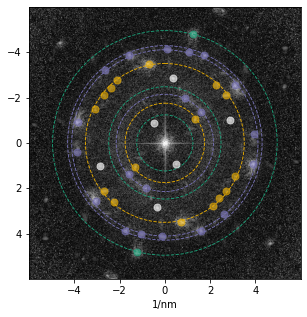

In [12]:
# create axis object
fig, ax = plt.subplots(figsize=(5, 5))

# plot settings
spot_alpha = 0.6
spot_size = 7
circle_linewidth = 0.9

ax.imshow(image_bc, cmap='gray', extent=[freq_crop[0], freq_crop[-1], freq_crop[-1], freq_crop[0]])
ax.set_xlabel('1/nm')
############################################
# plot peaks from the dataframe
for index, row in peak_df.iterrows():
    # use peak-specific color if assignment is made
    if row['Color'] != None:
        color = row['Color']
            
        ax.plot(freq_crop[row['x1']], freq_crop[row['y1']], 'o', color = color, alpha=spot_alpha, markersize=spot_size)
        ax.plot(freq_crop[row['x2']], freq_crop[row['y2']], 'o', color = color, alpha=spot_alpha, markersize=spot_size)

    # if no assignment is made, plot as white
    else:
        ax.plot(freq_crop[row['x1']], freq_crop[row['y1']], 'o', color = 'white', alpha=spot_alpha, markersize=spot_size)
        ax.plot(freq_crop[row['x2']], freq_crop[row['y2']], 'o', color = 'white', alpha=spot_alpha, markersize=spot_size)
############################################        
# plot dashed circles to show theoretical peak positions
for index, row in ref.iterrows():
    # get the color of this peak
    color = row['Color']

    # plot the circle
    circle = patches.Circle((0, 0), row['Inverse distance (nm-1)'], color=color, fill=False, linestyle='--', linewidth=circle_linewidth)
    ax.add_patch(circle)
    
plt.show()

### Highlight peak pairs in reciprocal space and perform inverse FFT to show their contributions in real space

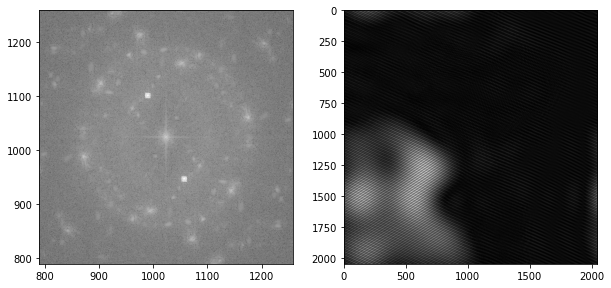

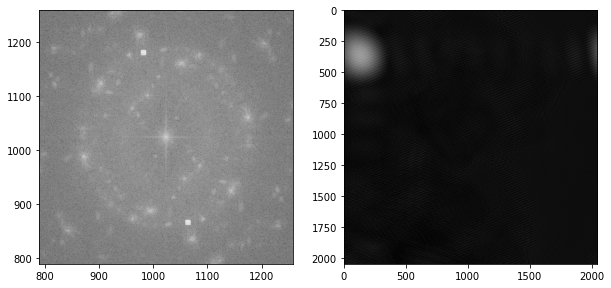

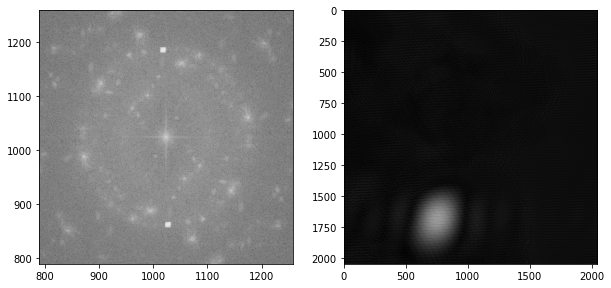

In [14]:
# randomly pick 3 peak pairs to check
# 1. if we are properly highlighting the peaks in the FFT image
# 2. how the image looks like after inverse FFT
peak_df_sample = peak_df[peak_df['h'].notnull()].sample(n=3)    # only choose those with assignments

################################ Strategy for highlighting peaks in the FFT image ################################
# 1. we don't just highlight the peak itself (which is just 1 pixel), but also a few neighbouring pixels around the peak 
neighbour_factor = 5    # control how many pixels around the peak are highlighted
# 2. to do that, we create a mask with a discount factor everywhere, but 1 at the peak and its neighbouring pixels
discount_factor = 0.01  # smaller discount factor means the highlighted region is highlighted more against the background
# 3. we then multiply the FFT image with the mask
# 4. and do an inverse FFT to show the contribution of the peak in real space
##################################################################################################################
for index, row in peak_df_sample.iterrows():
    # map coordinates from the cropped image to the original large image
    x1_coord = freq_crop_index[row['x1']]
    y1_coord = freq_crop_index[row['y1']]

    x2_coord = freq_crop_index[row['x2']]
    y2_coord = freq_crop_index[row['y2']]

    # mask: create a mask with a discount factor everywhere, but 1 at the peak and its neighbouring pixels
    mask = np.ones((fft_image.shape[0], fft_image.shape[1])) * discount_factor   
    # NB: y_coord and x_coord are swapped, because the mask uses (row, column) format
    mask[y1_coord - neighbour_factor : y1_coord + neighbour_factor, x1_coord - neighbour_factor : x1_coord + neighbour_factor] = 1
    mask[y2_coord - neighbour_factor : y2_coord + neighbour_factor, x2_coord - neighbour_factor : x2_coord + neighbour_factor] = 1
    ############################################
    # multiply fft_image with the mask
    fft_image_masked = np.fft.fftshift(fft_image) * mask

    # do an inverse FFT
    img_masked = np.fft.ifft2(fft_image_masked)

    # get the absolute value of the image
    img_masked = np.abs(img_masked)
    ############################################
    # get the power spectrum of the masked fft image
    fft_image_masked_power_spectrum = np.abs(fft_image_masked)**2
    # log power spectrum
    log_fft_image_masked_power_spectrum = np.log(fft_image_masked_power_spectrum)
    ############################################
    # plot the masked power spectrum and the masked image side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(log_fft_image_masked_power_spectrum, cmap='gray')

    ax2.imshow(img_masked, cmap='gray')

    # zoom in to the power spectrum
    lim = (freq_crop_index[0], freq_crop_index[-1])
    ax1.set_xlim(lim)
    ax1.set_ylim(lim)

    plt.show()

In [15]:
# now perform this peak highlighting and inverse FFT for all the assigned peaks
# the only difference is that we will also multiply the image with the peak-specific color

################################ Strategy for highlighting peaks in the FFT image ################################
# 1. we don't just highlight the peak itself (which is just 1 pixel), but also a few neighbouring pixels around the peak 
neighbour_factor = 5    # control how many pixels around the peak are highlighted
# 2. to do that, we create a mask with a discount factor everywhere, but 1 at the peak and its neighbouring pixels
discount_factor = 0.01  # smaller discount factor means the highlighted region is highlighted more against the background
# 3. we then multiply the FFT image with the mask
# 4. and do an inverse FFT to show the contribution of the peak in real space
# 5. we then multiply the image with the peak-specific color
##################################################################################################################
# create a matrix for highlighting regions from different planes
# the reconstruct matrix is the same size as the original image, but with 3 channels
reconstruct = np.zeros((image.size[0], image.size[1], 3))

for index, row in peak_df.iterrows():
    # check if any assignment is made, only use those which are assigned
    if row['Color'] != None:
        # map coordinates from the cropped image to the original large image
        x1_coord = freq_crop_index[row['x1']]
        y1_coord = freq_crop_index[row['y1']]

        x2_coord = freq_crop_index[row['x2']]
        y2_coord = freq_crop_index[row['y2']]

        # mask: create a mask with a discount factor everywhere, but 1 at the peak and its neighbouring pixels
        mask = np.ones((fft_image.shape[0], fft_image.shape[1])) * discount_factor   
        # NB: y_coord and x_coord are swapped, because the mask uses (row, column) format
        mask[y1_coord - neighbour_factor : y1_coord + neighbour_factor, x1_coord - neighbour_factor : x1_coord + neighbour_factor] = 1
        mask[y2_coord - neighbour_factor : y2_coord + neighbour_factor, x2_coord - neighbour_factor : x2_coord + neighbour_factor] = 1
        
        # multiply fft_image with the mask
        fft_image_masked = np.fft.fftshift(fft_image) * mask

        # do an inverse FFT
        img_masked = np.fft.ifft2(fft_image_masked)

        # get the absolute value of the image
        img_masked = np.abs(img_masked)
        ############################################
        # get the color of this peak
        color = row['Color']
        color = mcolors.hex2color(color)

        # generate a color array
        color_array = np.zeros((image.size[0], image.size[1], 3))
        color_array[:] = color

        # expand the image to 3 channels
        img_masked_3d = np.expand_dims(img_masked, axis=-1)
        # multiply the image with the color array
        img_masked_3d = img_masked_3d * color_array

        # add the colored image to the reconstruct matrix
        reconstruct += img_masked_3d

# normalize reconstruct matrix to 0-1 for plotting
reconstruct_norm = reconstruct / np.max(reconstruct)

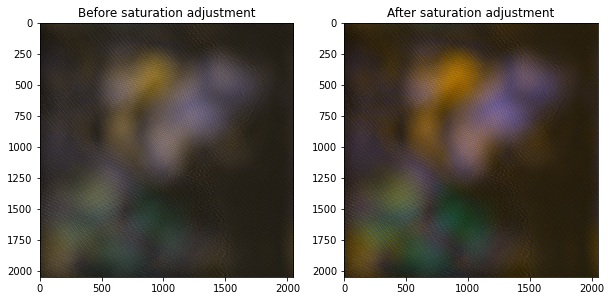

In [16]:
# increase the saturation for better visualization

# convert the pixel values to the 0-255 range and change the data type to uint8
reconstruct_255 = (reconstruct_norm * 255).astype(np.uint8)

# create a PIL Image from the numpy array
reconstruct_255 = Image.fromarray(reconstruct_255)

# adjust saturation using ImageEnhance
saturation_factor = 2   # 1: no change; >1: more saturated; <1: less saturated
enhancer = ImageEnhance.Color(reconstruct_255)
reconstruct_sat = enhancer.enhance(saturation_factor)

# compare before and after saturation adjustment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(reconstruct_norm)
ax1.set_title('Before saturation adjustment')

ax2.imshow(reconstruct_sat)
ax2.set_title('After saturation adjustment')

plt.show()

### Plot everything in the same figure
1. original TEM image
2. reconstructed image
3. power spectrum with no labels
4. power spectrum with peaks labeled

In [17]:
# create the legend
legend_elements = []

# group ref rows by color, extract the (hkl) with the same color
ref_grouped = ref.groupby('Color')

# create a dictionary: key is the color, value is the (hkl) list
legend_dict = {}
for name, group in ref_grouped:
    legend_dict[name] = group[['h', 'k', 'l']].values.tolist()

# process the values in the dictionary
# convert the [h, k, l] to string (hkl)
for key, value in legend_dict.items():
    for i in range(len(value)):
        value[i] = '(' + ''.join(str(x) for x in value[i]) + ')'

for key, value in legend_dict.items():
    # unpack the value list
    value = ', '.join(value)
    
    element = plt.Line2D([0], [0], color=key, label=value)
    legend_elements.append(element)

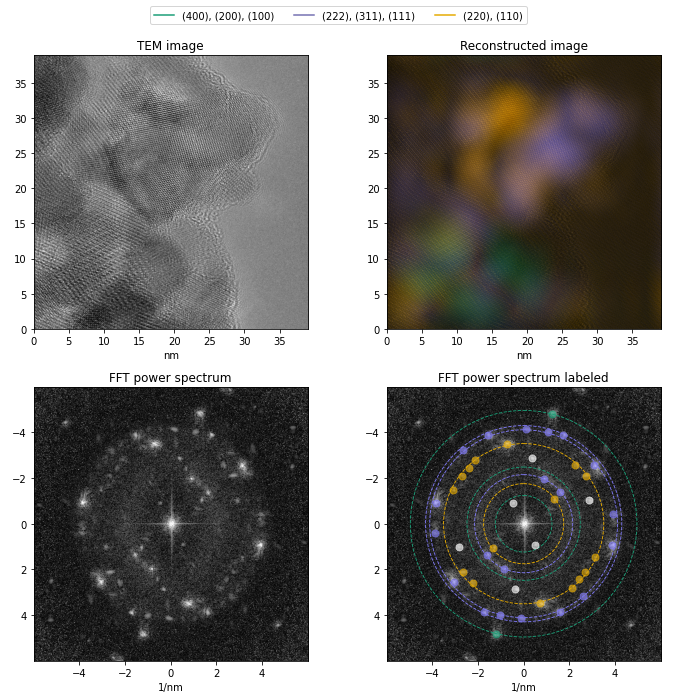

In [18]:
# create axis object
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
############################################
# define a separate ax_legend object
ax_legend = fig.add_subplot(111)
# hide the ax_legend object
ax_legend.axis('off')
# define the legend coordinates
legend_coor = (0.21, 1.05)
############################################
# 1. plot the original image
ax1.imshow(image, cmap='gray', extent=[0, total_len, 0, total_len])
ax1.set_xlabel('nm')
ax1.set_title('TEM image')
############################################
# 2. plot the reconstructed image
ax2.imshow(reconstruct_sat, extent=[0, total_len, 0, total_len])
ax2.set_xlabel('nm')
ax2.set_title('Reconstructed image')
############################################
# 3. plot the power spectrum
ax3.imshow(image_bc, cmap='gray', extent=[freq_crop[0], freq_crop[-1], freq_crop[-1], freq_crop[0]])
ax3.set_xlabel('1/nm')
ax3.set_title('FFT power spectrum')
############################################
# 4. plot the power spectrum with peaks labeled
spot_alpha = 0.6
spot_size = 7
circle_linewidth = 0.9
purple_color = '#7E78F3'

ax4.imshow(image_bc, cmap='gray', extent=[freq_crop[0], freq_crop[-1], freq_crop[-1], freq_crop[0]])
ax4.set_xlabel('1/nm')
ax4.set_title('FFT power spectrum labeled')

# plot peaks from the dataframe
for index, row in peak_df.iterrows():
    # use different colors for different peaks
    if row['Color'] != None:
        color = row['Color']
        # replace the original purple color with a lighter one for better visualization
        if color == '#7570b3':
            color = purple_color
        ax4.plot(freq_crop[row['x1']], freq_crop[row['y1']], 'o', color = color, alpha=spot_alpha, markersize=spot_size)
        ax4.plot(freq_crop[row['x2']], freq_crop[row['y2']], 'o', color = color, alpha=spot_alpha, markersize=spot_size)

    # if no assignment is made, plot as white
    else:
        ax4.plot(freq_crop[row['x1']], freq_crop[row['y1']], 'o', color = 'white', alpha=spot_alpha, markersize=spot_size)
        ax4.plot(freq_crop[row['x2']], freq_crop[row['y2']], 'o', color = 'white', alpha=spot_alpha, markersize=spot_size)
        
# plot dashed circles to show the theoretical peak positions
for index, row in ref.iterrows():
    # get the color of this peak
    color = row['Color']
    # replace the default purple color with a lighter one for better visualization
    if color == '#7570b3':
        color = purple_color

    # plot the circle
    circle = patches.Circle((0, 0), row['Inverse distance (nm-1)'], color=color, fill=False, linestyle='--', linewidth=circle_linewidth)
    ax4.add_patch(circle)
############################################
# add legend
ax_legend.legend(handles=legend_elements, ncol = 3, loc= legend_coor)

plt.tight_layout()

fig_name = file.split('.png')[0] + '_reconstruct.png'
plt.savefig(fig_name, dpi=300)

plt.show()